## 导入

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

import pandas as pd
import matplotlib.image as mpimg
import seaborn as sns
import random

使用Python3.5.2（Anaconda）开发，TensorFlow版本是：

In [52]:
tf.__version__

'1.6.0'

## 神经网络的配置

方便起见，在这里定义神经网络的配置，你可以很容易找到或改变这些数值，然后重新运行Notebook。

In [53]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

## 载入数据

MNIST数据集大约12MB，如果没在文件夹中找到就会自动下载。

In [54]:
train = pd.read_csv("data/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# trainLabels is y_train
train["label"] = train["label"].astype('int32')
trainLabels = train["label"]

# Drop 'label' column
# train pixels is x_train
trainPixels = train.drop(labels = ["label"],axis = 1)
# free some space
del train

In [56]:
trainPixels = trainPixels.values

In [59]:
with tf.Session() as ses:
    NUM_CLASSES = 10

    labels = trainLabels
    onehot_labels = tf.one_hot(labels, depth=10, on_value=None, off_value=None, axis=None, dtype=None, name=None).eval()

在下面的源码中，有很多地方用到了数据维度。它们只在一个地方定义，因此我们可以在代码中使用这些数字而不是直接写数字。

In [61]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

函数用来根据给定大小创建TensorFlow变量，并将它们用随机值初始化。需注意的是在此时并未完成初始化工作，仅仅是在TensorFlow图里定义它们。

In [62]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [63]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### 创建卷积层的帮助函数

这个函数为TensorFlow在计算图里创建了新的卷积层。这里并没有执行什么计算，只是在TensorFlow图里添加了数学公式。

假设输入的是四维的张量，各个维度如下：

1. 图像数量
2. 每张图像的Y轴
3. 每张图像的X轴
4. 每张图像的通道数

输入通道可能是彩色通道，当输入是前面的卷积层生成的时候，它也可能是滤波通道。

输出是另外一个4通道的张量，如下：

1. 图像数量，与输入相同
2. 每张图像的Y轴。如果用到了2x2的池化，是输入图像宽高的一半。
3. 每张图像的X轴。同上。
4. 卷积滤波生成的通道数。

In [64]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

### 转换一个层的帮助函数

卷积层生成了4维的张量。我们会在卷积层之后添加一个全连接层，因此我们需要将这个4维的张量转换成可被全连接层使用的2维张量。

In [65]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### 创建一个全连接层的帮助函数

这个函数为TensorFlow在计算图中创建了一个全连接层。这里也不进行任何计算，只是往TensorFlow图中添加数学公式。

输入是大小为`[num_images, num_inputs]`的二维张量。输出是大小为`[num_images, num_outputs]`的2维张量。

In [66]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### 占位符 （Placeholder）变量

Placeholder是作为图的输入，每次我们运行图的时候都可能会改变它们。将这个过程称为feeding placeholder变量，后面将会描述它。

首先我们为输入图像定义placeholder变量。这让我们可以改变输入到TensorFlow图中的图像。这也是一个张量（tensor），代表一个多维向量或矩阵。数据类型设置为float32，形状设为`[None, img_size_flat]`，`None`代表tensor可能保存着任意数量的图像，每张图象是一个长度为`img_size_flat`的向量。

In [67]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

卷积层希望`x`被编码为4维张量，因此我们需要将它的形状转换至`[num_images, img_height, img_width, num_channels]`。注意`img_height == img_width == img_size`，如果第一维的大小设为-1， `num_images`的大小也会被自动推导出来。转换运算如下：

In [68]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

接下来我们为输入变量`x`中的图像所对应的真实标签定义placeholder变量。变量的形状是`[None, num_classes]`，这代表着它保存了任意数量的标签，每个标签是长度为`num_classes`的向量，本例中长度为10。

In [69]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

我们也可以为class-number提供一个placeholder，但这里用argmax来计算它。这里只是TensorFlow中的一些操作，没有执行什么运算。


tf.argmax(array, dimension=1) = np.argmax(array, axis=1)<p>
如果array是多维数组，dimemsion或axis=1的意思就是取每个小数组中的最大值组成新的数组<p>
axis=0: 取同一位置下有最大值的数组序号，遍历每个位置得到新的数组<p>
简单的说，axis指定了在矩阵的哪一个维度上进行比较

In [70]:
y_true_cls = tf.argmax(y_true, dimension=1)

### 卷积层 1

创建第一个卷积层。将`x_image`当作输入，创建`num_filters1`个不同的滤波器，每个滤波器的宽高都与 `filter_size1`相等。最终我们会用2x2的max-pooling将图像降采样，使它的尺寸减半。

In [71]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

检查卷积层输出张量的大小。它是（？,14, 14, 16），这代表着有任意数量的图像（？代表数量），每张图像有14个像素的宽和高，有16个不同的通道，每个滤波器各有一个通道。

In [72]:
layer_conv1

<tf.Tensor 'Relu_3:0' shape=(?, 14, 14, 16) dtype=float32>

### 卷积层 2

创建第二个卷积层，它将第一个卷积层的输出作为输入。输入通道的数量对应着第一个卷积层的滤波数。

In [73]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

核对一下这个卷积层输出张量的大小。它的大小是（？， 7， 7， 36）,其中？也代表着任意数量的图像，每张图有7像素的宽高，每个滤波器有36个通道。

In [74]:
layer_conv2

<tf.Tensor 'Relu_4:0' shape=(?, 7, 7, 36) dtype=float32>

### 转换层

这个卷积层输出一个4维张量。现在我们想将它作为一个全连接网络的输入，这就需要将它转换成2维张量。

In [75]:
layer_flat, num_features = flatten_layer(layer_conv2)

这个张量的大小是（？， 1764），意味着共有一定数量的图像，每张图像被转换成长为1764的向量。其中1764 = 7 x 7 x 36。

In [77]:
num_features

1764

In [76]:
layer_flat

<tf.Tensor 'Reshape_3:0' shape=(?, 1764) dtype=float32>

### 全连接层 1

往网络中添加一个全连接层。输入是一个前面卷积得到的被转换过的层。全连接层中的神经元或节点数为`fc_size`。我们可以用ReLU来学习非线性关系。

In [78]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

全连接层的输出是一个大小为（？，128）的张量，？代表着一定数量的图像，并且`fc_size` == 128。

In [79]:
layer_fc1

<tf.Tensor 'Relu_5:0' shape=(?, 128) dtype=float32>

### 全连接层 2

添加另外一个全连接层，它的输出是一个长度为10的向量，它确定了输入图是属于哪个类别。这层并没有用到ReLU。

In [80]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [81]:
layer_fc2

<tf.Tensor 'add_7:0' shape=(?, 10) dtype=float32>

### 预测类别

第二个全连接层估算了输入图有多大的可能属于10个类别中的其中一个。然而，这是很粗略的估计并且很难解释，因为数值可能很小或很大，因此我们会对它们做归一化，将每个元素限制在0到1之间，并且相加为1。这用一个称为softmax的函数来计算的，结果保存在`y_pred`中。

In [82]:
y_pred = tf.nn.softmax(layer_fc2)

类别数字是最大元素的索引。

In [83]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

### 优化损失函数

为了使模型更好地对输入图像进行分类，我们必须改变`weights`和`biases`变量。首先我们需要对比模型`y_pred`的预测输出和期望输出的`y_true`，来了解目前模型的性能如何。

交叉熵（cross-entropy）是在分类中使用的性能度量。交叉熵是一个常为正值的连续函数，如果模型的预测值精准地符合期望的输出，它就等于零。因此，优化的目的就是通过改变网络层的变量来最小化交叉熵。

TensorFlow有一个内置的计算交叉熵的函数。这个函数内部计算了softmax，所以我们要用`layer_fc2`的输出而非直接用`y_pred`,因为`y_pred`上已经计算了softmax。

In [84]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

我们为每个图像分类计算了交叉熵，所以有一个当前模型在每张图上表现的度量。但是为了用交叉熵来指导模型变量的优化，我们需要一个额外的标量值，因此简单地利用所有图像分类交叉熵的均值。

In [85]:
cost = tf.reduce_mean(cross_entropy)

### 优化方法

既然我们有一个需要被最小化的损失度量，接着就可以建立优化一个优化器。这个例子中，我们使用的是梯度下降的变体`AdamOptimizer`。

优化过程并不是在这里执行。实际上，还没计算任何东西，我们只是往TensorFlow图中添加了优化器，以便之后的操作。

In [86]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### 性能度量

我们需要另外一些性能度量，来向用户展示这个过程。

这是一个布尔值向量，代表预测类型是否等于每张图片的真实类型。

In [87]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

上面的计算先将布尔值向量类型转换成浮点型向量，这样子False就变成0，True变成1，然后计算这些值的平均数，以此来计算分类的准确度。

In [88]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## 运行TensorFlow

### 创建TensorFlow会话（session）

一旦创建了TensorFlow图，我们需要创建一个TensorFlow会话，用来运行图。

In [89]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = tf.Session(config=config)

### 初始化变量

我们需要在开始优化weights和biases变量之前对它们进行初始化。

In [90]:
session.run(tf.global_variables_initializer())

### 用来优化迭代的帮助函数

在训练集中有50,000张图。用这些图像计算模型的梯度会花很多时间。因此我们利用随机梯度下降的方法，它在优化器的每次迭代里只用到了一小部分的图像。

如果内存耗尽导致电脑死机或变得很慢，你应该试着减少这些数量，但同时可能还需要更优化的迭代。

In [91]:
train_batch_size = 64

函数执行了多次的优化迭代来逐步地提升网络层的变量。在每次迭代中，从训练集中选择一批新的数据，然后TensorFlow用这些训练样本来执行优化器。每100次迭代会打印出相关信息。

In [94]:
# Counter for total number of iterations performed so far.
total_iterations = 256
# trainPixels = trainPixels.values
# print(trainPixels.values)

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.

        index = random.randint(0,41936)
        x_batch = trainPixels[index:index + 64]
        y_true_batch = onehot_labels[index:index + 64]
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

## 10,000次优化迭代后的性能

经过10,000次优化迭代后，测试集上的分类准确率高达99%。

In [95]:
optimize(num_iterations=9000) # We performed 1000 iterations above. [9000]

Optimization Iteration:    301, Training Accuracy:  67.2%
Optimization Iteration:    401, Training Accuracy:  82.8%
Optimization Iteration:    501, Training Accuracy:  90.6%
Optimization Iteration:    601, Training Accuracy:  95.3%
Optimization Iteration:    701, Training Accuracy:  95.3%
Optimization Iteration:    801, Training Accuracy:  95.3%
Optimization Iteration:    901, Training Accuracy:  95.3%
Optimization Iteration:   1001, Training Accuracy:  98.4%
Optimization Iteration:   1101, Training Accuracy: 100.0%
Optimization Iteration:   1201, Training Accuracy:  93.8%
Optimization Iteration:   1301, Training Accuracy: 100.0%
Optimization Iteration:   1401, Training Accuracy: 100.0%
Optimization Iteration:   1501, Training Accuracy:  98.4%
Optimization Iteration:   1601, Training Accuracy:  96.9%
Optimization Iteration:   1701, Training Accuracy: 100.0%
Optimization Iteration:   1801, Training Accuracy:  96.9%
Optimization Iteration:   1901, Training Accuracy:  95.3%
Optimization I

In [97]:
argmaxtensor = tf.argmax(y_pred, 1)

In [98]:
# session.run(tf.global_variables_initializer())
# softmax_tensor = session.graph.get_tensor_by_name('final_result:0')
test = pd.read_csv("data/test.csv")
print(test.shape)
test.head()
test = test.values

(28000, 784)


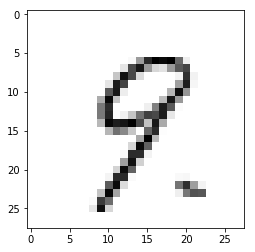

In [99]:
inputPic = test[2].reshape(28,28)
plt.imshow(inputPic, cmap=plt.cm.binary)
plt.show()

In [100]:
feed_dict = {x: test[2].reshape(1,784)}
y_pred = session.run(argmaxtensor, feed_dict=feed_dict)
print(y_pred)

[9]


In [101]:
# answers = []

# for img in test:
#     feed_dict = {x: img.reshape(1,784)}
#     y_pred = session.run(argmaxtensor, feed_dict=feed_dict)
#     answers.append(y_pred)

In [102]:
# print(answers[27999])

现在我们已经用TensorFlow完成了任务，关闭session，释放资源。

In [103]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()